In [177]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import plot_confusion_matrix
from scipy.ndimage import convolve1d

from typing import List, Tuple

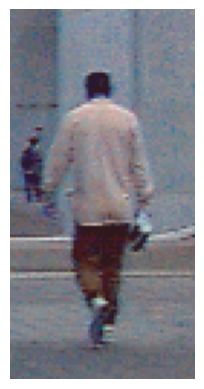

In [158]:
positive_image = cv2.imread(os.path.join('data', 'train', 'pos', 'per00001.ppm'))

plt.imshow(positive_image)  
plt.axis('off')
plt.show()

In [159]:
def normalise_l2_threshold(
        blocked_histograms: np.ndarray,
        threshold: float = 0.2,
        epsilon: float = 1e-6
) -> np.ndarray:
    thresholded = np.minimum(blocked_histograms, threshold)
    normalised = thresholded/np.sqrt(np.power(thresholded,2)+epsilon)
    return normalised

In [160]:
def histogram_of_gradients(
        image: np.ndarray,
        l2_th_normalise: bool = False,
        cell_size: int = 8,
        bin_count: int = 9,
        block_size: int = 2,
        epsilon: float = 1e-6
) -> np.ndarray:
    bin_width: float = np.pi/bin_count
    fine_grained_bins: np.ndarray = np.arange(0, np.pi + bin_width, bin_width/2)
    bin_centers: np.ndarray = np.arange(bin_width/2, np.pi, bin_width)

    dx = convolve1d(np.int32(image), np.array([-1, 0, 1]), 1)
    dy = convolve1d(np.int32(image), np.array([-1, 0, 1]), 0)

    magnitude = np.sqrt(np.max(dx**2 + dy**2, axis=-1))
    phase = np.arctan2(np.max(dy, axis=-1), np.max(dx, axis=-1))

    phase = np.where(phase < 0, phase + np.pi, phase)

    bins = np.zeros((image.shape[0]//cell_size, image.shape[1]//cell_size, bin_count))

    for i in range(image.shape[0]//cell_size):
        for j in range(image.shape[1]//cell_size):
            fine_grained_assignment = np.digitize(phase[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size], fine_grained_bins)
            
            destination = np.mod(1+fine_grained_assignment, bin_count)//2

            d_l = np.abs(phase[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size] - bin_centers[destination-1])/bin_width
            d_r = np.abs(phase[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size] - bin_centers[destination])/bin_width

            for k in range(bin_count):
                bins[i,j,k] += np.sum((d_l*magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size])[destination == k])
                bins[i,j,k-1] += np.sum((d_r*magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size])[destination == k])

    blocked_histograms = np.zeros((image.shape[0]//cell_size-1)*(image.shape[1]//cell_size-1)*bin_count*block_size**2)
    c = bin_count*block_size**2
    for i in range(image.shape[0]//cell_size-block_size+1):
        for j in range(image.shape[1]//cell_size-block_size+1):
            histogram = bins[i:i+block_size,j:j+block_size,:]
            norm = np.linalg.norm(bins[i:i+block_size,j:j+block_size,:])
            normalised = histogram/np.sqrt(np.power(norm,2)+epsilon)
            blocked_histograms[i*(image.shape[1]//cell_size-1)*c + j*c:i*(image.shape[1]//cell_size-1)*c + (j+1)*c] = normalised.flatten()

    return normalise_l2_threshold(blocked_histograms) if l2_th_normalise else blocked_histograms



In [161]:
F = histogram_of_gradients(cv2.imread(os.path.join("data", "train", "pos", f"per{60:05d}.ppm")))
print(F)

[0.30535163 0.26263104 0.15151807 ... 0.         0.         0.02702326]


In [162]:
HOG_data = np.zeros([2*100, 3781], np.float32)
for i in range(100):
    F = histogram_of_gradients(cv2.imread(os.path.join("data", "train", "pos", f"per{i+1:05d}.ppm")))
    HOG_data[i,0] = 1
    HOG_data[i,1:] = F
    F = histogram_of_gradients(cv2.imread(os.path.join("data", "train", "neg", f"neg{i+1:05d}.png")))
    HOG_data[i+100,0] = 0
    HOG_data[i+100,1:] = F

In [163]:
HOG_data_test = np.zeros([2*100, 3781], np.float32)
for i in range(100):
    F = histogram_of_gradients(cv2.imread(os.path.join("data", "train", "pos", f"per{i+101:05d}.ppm")))
    HOG_data_test[i,0] = 1
    HOG_data_test[i,1:] = F
    F = histogram_of_gradients(cv2.imread(os.path.join("data", "train", "neg", f"neg{i+101:05d}.png")))
    HOG_data_test[i+100,0] = 0
    HOG_data_test[i+100,1:] = F

In [184]:
labels = HOG_data[:,0]
data = HOG_data[:,1:]

svm = LinearSVC(C=1e6, max_iter=1e5)
svm.fit(data, labels)

lp = svm.predict(data)

c:\Users\igor\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


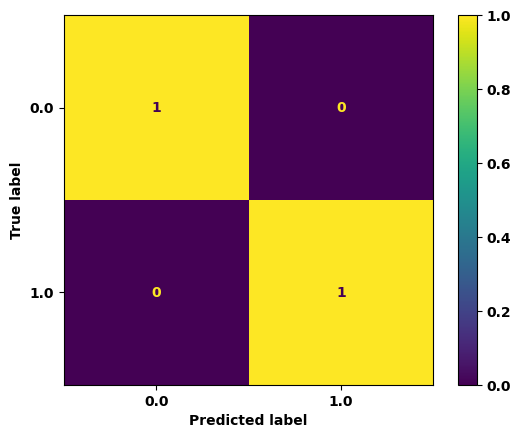

In [185]:
plot_confusion_matrix(svm, data, labels, normalize='true')
plt.show()

c:\Users\igor\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


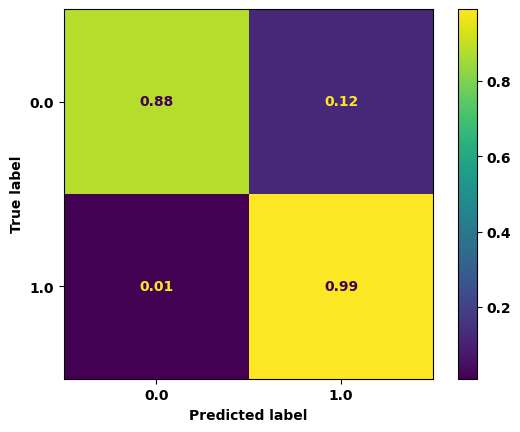

In [186]:
test_data = HOG_data_test[:,1:]
test_labels = HOG_data_test[:,0]

plot_confusion_matrix(svm, test_data, test_labels, normalize='true')
plt.show()


In [182]:
def iou(rect_1: Tuple[int], rect_2: Tuple[int]) -> float:
    t, l, b, r = rect_1
    t_, l_, b_, r_ = rect_2
    intersection = max(0, min(b, b_) - max(t, t_)) * max(0, min(r, r_) - max(l, l_))
    union = (b - t) * (r - l) + (b_ - t_) * (r_ - l_) - intersection
    return intersection/union


def nms(
    rectangles: List[Tuple[float, Tuple[int]]],
    max_output_size: int = 10,
    iou_threshold: float = 0.4
    ) -> List[Tuple[int]]:
    sorted_rectangles = sorted(rectangles, key=lambda x: x[0], reverse=True)
    active: np.ndarray = np.ones(len(sorted_rectangles), dtype=bool)
    nms_rectangles = []
    for idx, rect_1 in enumerate(sorted_rectangles):
        if active[idx]:
            nms_rectangles.append(rect_1[1])
            if len(nms_rectangles) == max_output_size: break
            for jdx, rect_2 in enumerate(sorted_rectangles):
                if iou(rect_1[1], rect_2[1]) > iou_threshold:
                    active[jdx] = False
    return [rect for rect in nms_rectangles]


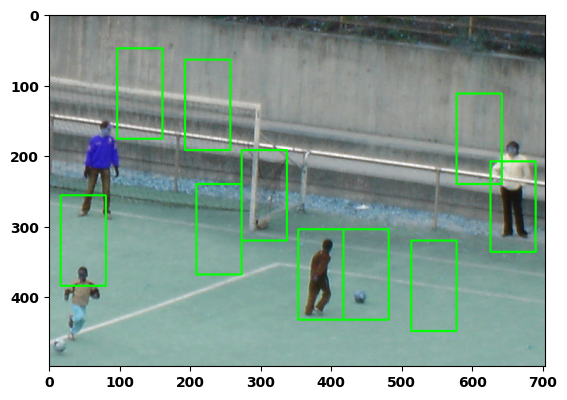

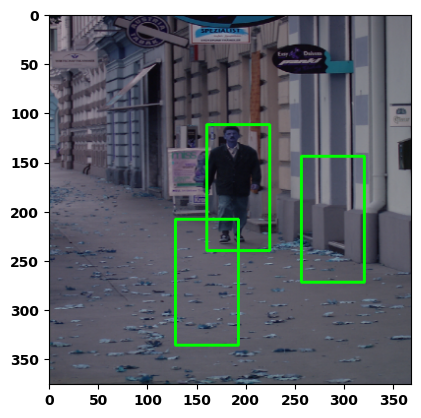

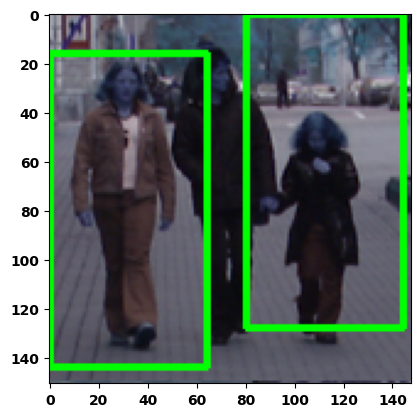

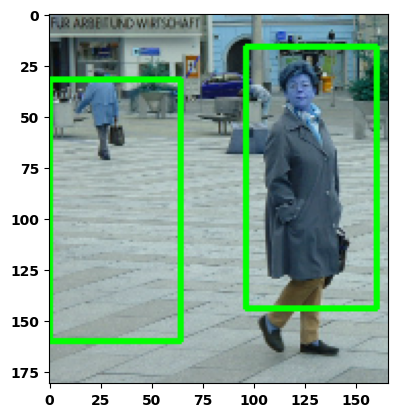

In [195]:
scales = [(1,1), (1.3, 1.7),  (1,1), (2,2)]
ppl = [10,3,4,2]
images = [cv2.imread(os.path.join("data", "test", f"testImage{i+1}.png")) for i in range(4)]

w_shape = (128, 64)
step = 16

for image, pp, scale in zip(images, ppl, scales):
    image = cv2.resize(image, (int(image.shape[1]/scale[0]), int(image.shape[0]/scale[1])))
    rectangles = []
    for row in range(0, image.shape[0]-w_shape[0], step):
        for col in range(0, image.shape[1]-w_shape[1], step):
            p = np.array([histogram_of_gradients(image[row:row+w_shape[0], col:col+w_shape[1], :])])
            if svm.predict(p): rectangles.append((svm.decision_function(p), (col, row, col+w_shape[1], row+w_shape[0])))
    
    for rect in nms(rectangles, pp): 
        cv2.rectangle(image, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()